Cleaning and analysis of the data scraped in the previous task. 
Empty cells are handled, then outliers. 
Then PCA is checked for usefulness (answer is 'perhaps'), some clusterings are attempted (kmeans for different k) and rougly profiled with pairplot (scatterplot pairwise all variables). 

TO DO plan is to profile in more detail one of the clusterings and try some price modelling for most frequent models. 

In [1]:
import pandas as pd

df = pd.read_csv("raw_data_2.csv", encoding="utf-8", delimiter="|")
#raw data from previous task

In [16]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

In [2]:
#Importing Libraries   #may be some redundancies
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering     #ie this not yet used
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [3]:
#checking the features
df.info()    #curiosity - columns 1-6 were strings when going from scraping dataframe to 'raw_data.csv',
             #yet they are read as numericals now

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4491 entries, 0 to 4490
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         4491 non-null   object 
 1   year_of_prod  4491 non-null   float64
 2   price_EUR     4491 non-null   float64
 3   price_kn      4491 non-null   float64
 4   Mileage_kms   3597 non-null   float64
 5   kWs           4054 non-null   float64
 6   cc            3954 non-null   float64
 7   nofviews      4491 non-null   int64  
 8   manufacturer  4491 non-null   object 
 9   model         28 non-null     object 
 10  seller        4235 non-null   object 
 11  location      4491 non-null   object 
 12  ad_URL        4491 non-null   object 
 13  image         4137 non-null   object 
dtypes: float64(6), int64(1), object(7)
memory usage: 491.3+ KB


 'model' column is rather sparsly filled out, in this analysis I'm dropping it. Also dropping rows with incomplete data.
 
Later I'll return to raw data and try to check if that can be fixed with hugging face - because the car model is usually written in the title, altough not uniformly. With car model a GPT could perhaps reconstruct model-inherent missing data (kWs, cc), but not unit-spcific data (mileage, year) 

In [4]:
df=df.drop('model',axis=1)              
df=df.dropna()
df.info()                                    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3240 entries, 1 to 4490
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         3240 non-null   object 
 1   year_of_prod  3240 non-null   float64
 2   price_EUR     3240 non-null   float64
 3   price_kn      3240 non-null   float64
 4   Mileage_kms   3240 non-null   float64
 5   kWs           3240 non-null   float64
 6   cc            3240 non-null   float64
 7   nofviews      3240 non-null   int64  
 8   manufacturer  3240 non-null   object 
 9   seller        3240 non-null   object 
 10  location      3240 non-null   object 
 11  ad_URL        3240 non-null   object 
 12  image         3240 non-null   object 
dtypes: float64(6), int64(1), object(6)
memory usage: 354.4+ KB


URLs are redundant atributes for now, kept them as exercise
'year_of_production' I'll replace with 'age'
'manufacturer' needs some formatting/fixing by hand. for instance there are "LAND ROVER", "land rover", "rover" and some others, all refering to the same.  
'seller' attribute is an attempt to distinguish does an used car come from a used car dealership or from a private person, previous owner. In some places that info might be relevant. Advisor pointed out that it is not car model-inherent info.

In [5]:
current_yr=2023
df["year_of_prod"]=df["year_of_prod"].apply(lambda x: current_yr-x)
df = df.rename(columns={'year_of_prod': 'age'}) 
df["age"]                   #za storage mi je draze da pise godina proizvodnje, tek za analizu transformiram u starost. 

1       5.0
2       5.0
3       5.0
4       5.0
5       5.0
       ... 
4486    6.0
4487    6.0
4488    6.0
4489    6.0
4490    5.0
Name: age, Length: 3240, dtype: float64

In [6]:
pd.set_option('display.max_rows', 90)
p=df["manufacturer"].value_counts()
#p=p.sort_index()
print(p)

VW          324
BMW         280
Audi        254
Renault     228
Opel        190
           ... 
LIMITED       1
A3            1
GLC           1
MASERATI      1
BURSTNER      1
Name: manufacturer, Length: 91, dtype: int64


so we have a mess, as mentioned. .lower() fixes some, other are fixed 'by hand'

In [9]:
df["manufacturer"]=df["manufacturer"].apply(lambda x:x.lower())
df["manufacturer"]=df["manufacturer"].replace({"a3":"audi", "a6":"audi", "škoda":"skoda","mercedes-benz":"mercedes","volkswagen":"vw",
                                               "land":"land rover", "rover":"land rover", "octavia":"skoda", "mazda3":"mazda",
                                               "astra":"opel","alfa romeo":"alfa", "duster":"dacia", "ds7":"ds", "golf":"vw",
                                               "burstner":"citroen","glc":"mercedes","insignia":"opel","limited":"renault"})
print(df["manufacturer"].value_counts().sort_index())

alfa           40
aston           2
audi          288
bentley         3
bmw           280
chevrolet      22
chrysler        3
citroen        73
cupra           5
dacia          73
daewoo         12
dodge           1
ds              4
ferrari         2
fiat           58
ford          106
honda          10
hyundai        40
infiniti        5
jaguar         38
jeep           12
kia            12
lada            6
lancia          5
land rover     93
lexus           4
maserati        2
mazda          67
mercedes      223
mini           16
mitsubishi      7
nissan         47
opel          382
peugeot       180
porsche        22
renault       357
seat           38
skoda         204
smart          15
suzuki         24
tesla           2
toyota         30
volvo          91
vw            335
zastava         1
Name: manufacturer, dtype: int64


In [10]:
p=df["seller"].value_counts().to_dict()
pd.set_option('display.max_rows', 9000)
#I introduce a feature/attribute, might turn out useless, might not 
df["sellerSize"]= df["seller"].apply(lambda x: p[x])

In [11]:
p=df["location"].value_counts()#.to_dict()
pd.set_option('display.max_rows', 9000)
print(p)
# mess

 Grad Zagreb                                   845
Inozemstvo                                     459
 01/2013-000                                   234
Grad Zagreb                                    234
 091/444-0757                                  233
 Istarska                                      161
 Splitsko-dalmatinska                          104
 01/2925-255                                    91
 Zagrebačka                                     86
 Primorsko-goranska                             85
 Istarska (Pogledaj na karti)                   67
 Grad Zagreb (Pogledaj na karti)                55
 Zadarska                                       42
 Karlovačka                                     37
 Primorsko-goranska (Pogledaj na karti)         31
 Sisačko-moslavačka                             30
 Varaždinska                                    27
Splitsko-dalmatinska                            26
Brodsko-posavska                                26
 Virovitičko-podravska         

In [12]:
df["location"]=df["location"].apply(lambda x: x.strip().split('(')[0].strip())
df["location"]=df["location"].replace({"01/2013-000":"Grad Zagreb","01/2925-255":"Grad Zagreb","091/444-0757":"Grad Zagreb","052/772-425":"Istarska"})
print(df["location"].value_counts())

Grad Zagreb               1692
Inozemstvo                 459
Istarska                   266
Splitsko-dalmatinska       137
Primorsko-goranska         120
Zagrebačka                 117
Sisačko-moslavačka          51
Zadarska                    47
Karlovačka                  47
Brodsko-posavska            45
Osječko-baranjska           39
Varaždinska                 36
Krapinsko-zagorska          27
Virovitičko-podravska       26
Bjelovarsko-bilogorska      25
Koprivničko-križevačka      25
Vukovarsko-srijemska        25
Međimurska                  15
Ličko-senjska               15
Požeško-slavonska           13
Dubrovačko-neretvanska      10
Šibensko-kninska             3
Name: location, dtype: int64


In [60]:
#df.to_csv("data_cleaned.csv", sep='|', encoding='utf-8',index=False)

In [13]:
#import pandas as pd
#df = pd.read_csv("data_cleaned.csv", encoding="utf-8", delimiter="|")

In [2]:
df.describe()

age     price_EUR      price_kn    Mileage_kms          kWs  \
count  3240.000000  3.240000e+03  3.240000e+03    3240.000000  3240.000000   
mean      7.891049  2.364636e+04  1.781635e+05  128284.313889   108.417901   
std       6.835078  3.622678e+04  2.729507e+05   77200.804690    74.094835   
min       0.000000  1.000000e+00  7.530000e+00       1.000000    18.000000   
25%       4.000000  9.900000e+03  7.459155e+04   80000.000000    74.000000   
50%       5.000000  1.656500e+04  1.248090e+05  121174.500000    92.000000   
75%       9.000000  2.890000e+04  2.177470e+05  168800.500000   121.000000   
max      53.000000  1.300000e+06  9.794850e+06  542000.000000  2200.000000   

                cc     nofviews   sellerSize  
count  3240.000000  3240.000000  3240.000000  
mean   1774.737963   446.902778   207.689506  
std     585.687596   443.442009   177.337274  
min       1.000000    13.000000     1.000000  
25%    1461.000000   175.000000    26.000000  
50%    1598.000000   360.000000   188.000000  
75%    1995.000000   482.000000   405.000000  
max    5950.000000  3540.000000   499.000000

Cleaning the outliers and clearly incorrect data. 
 nofviews could also turn out to be useless - it is probably not carmodel-specific, and definitely is connected to how long the ad was listed. 

 first quartile of sellerSize gives off skewness - very small number of natural persons, mainly dealerships. 
 
 prices are also problematic, we have a lot of cars sold for spare parts and scrap listed for 0/1 euro. Also there is a Renault clio for about 2e10 euro. 

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'price_EUR'}>,
        <Axes: title={'center': 'price_kn'}>],
       [<Axes: title={'center': 'Mileage_kms'}>,
        <Axes: title={'center': 'kWs'}>, <Axes: title={'center': 'cc'}>],
       [<Axes: title={'center': 'nofviews'}>,
        <Axes: title={'center': 'sellerSize'}>, <Axes: >]], dtype=object)

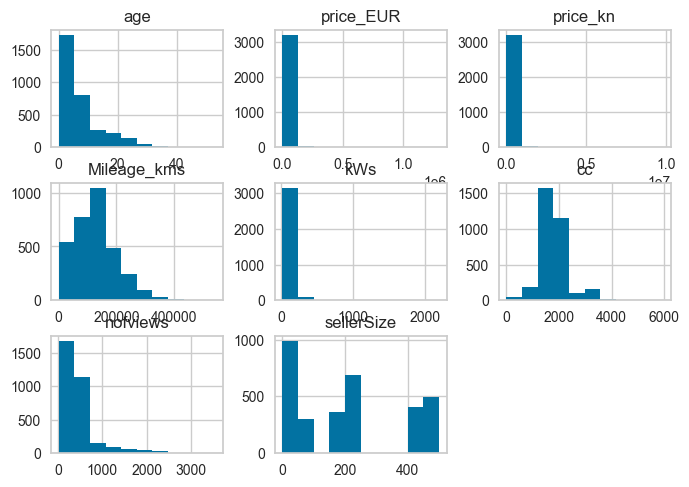

In [22]:
df.hist()
 

Here I see that prices, kws and cc definitely need some outlier-cutting, price_EUR and price_kn are probably the same variable, corr~.999

3163  after


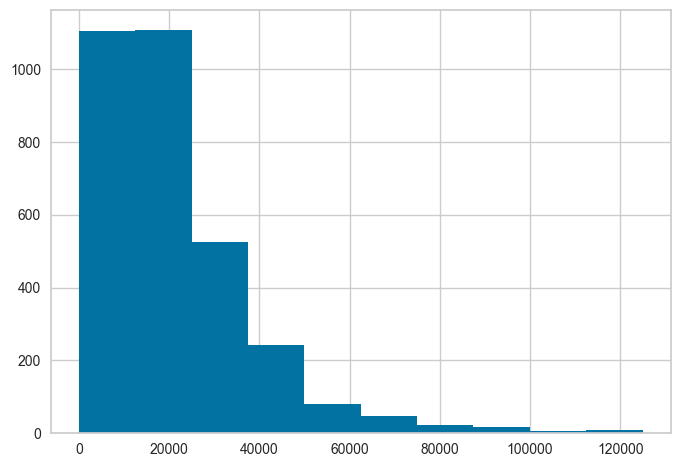

In [25]:
df=df[(df["price_EUR"]<13e4)]
df=df[(df["price_EUR"]>1)]    #I carefully chip away
df["price_EUR"].hist() 
print(len(df), " after") 

34     3     3093


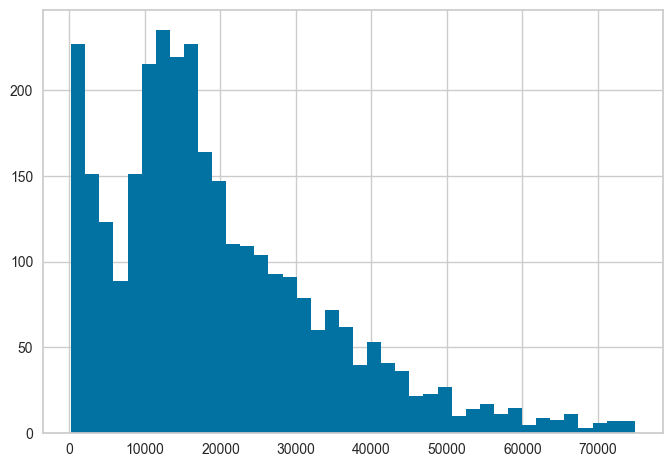

In [27]:
""" df=df[(df["price_EUR"]<9.5e4)]
df=df[(df["price_EUR"]>100)]
df["price_EUR"].hist(bins=30) 
print(len(df[(df["price_EUR"]>7.5e4)]) , "   ",len(df[(df["price_EUR"]<200)]) ,"   ", len(df)) """
df=df[(df["price_EUR"]<7.5e4)]
df=df[(df["price_EUR"]>200)]
df["price_EUR"].hist(bins=40) 
print(len(df[(df["price_EUR"]>6.5e4)]) , "   ",len(df[(df["price_EUR"]<300)]) ,"   ", len(df))

s ovim sam zadovoljan, i dopustam da mozda se moze naci auto u skoro voznom stanju za 201 euro. 
I'm content with this, I allow one can find a functioning vehicle for 201 euro. 

In [28]:
#df["tecaj"]=df["price_kn"]/df["price_EUR"]
#df["tecaj"].hist(bins=40)
 
#df=df.drop("tecaj",axis=1)                #ran a 'dumb' test if all prices give the same exchange rate, they do, so price_kn is redundant. 
                                           #could've done it with simple corr check :)
df.describe()   #bacim oko koja jos varijabla izgleda ruzno. 

age     price_EUR       price_kn    Mileage_kms          kWs  \
count  3093.000000   3093.000000    3093.000000    3093.000000  3093.000000   
mean      7.840608  19685.519576  148320.548513  130649.929195   103.014226   
std       6.589576  14454.300564  108905.927365   75745.817890    65.036504   
min       0.000000    220.000000    1657.590000       1.000000    18.000000   
25%       4.000000   9900.000000   74591.550000   83800.000000    74.000000   
50%       5.000000  16400.000000  123565.800000  123000.000000    89.000000   
75%       9.000000  27350.000000  206068.580000  169000.000000   118.000000   
max      53.000000  74900.000000  564334.050000  542000.000000  2200.000000   

                cc     nofviews   sellerSize  
count  3093.000000  3093.000000  3093.000000  
mean   1738.611057   444.613644   201.601681  
std     518.751590   444.329776   175.480697  
min       1.000000    13.000000     1.000000  
25%    1461.000000   172.000000    26.000000  
50%    1598.000000   360.000000   188.000000  
75%    1991.000000   478.000000   405.000000  
max    5461.000000  3540.000000   499.000000

17     35     3093


<Axes: >

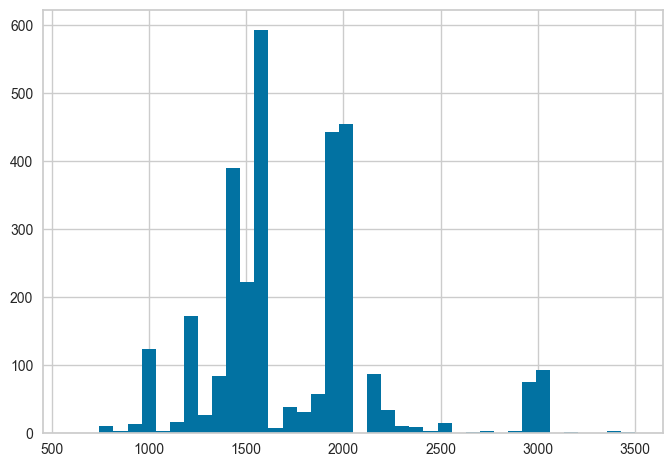

In [29]:
# I asked google what are realistic cc-s for a homologised personal vehicle
print(len(df[(df["cc"]>=3500)]) , "   ",len(df[(df["cc"]<=300)]) ,"   ", len(df))   #1     25     3093 #1     2     3067
df=df[(df["cc"]<3500)]
df=df[(df["cc"]>300)]
df["cc"].hist(bins=40) 
#mozda nisam zadnjih 15 vecih od 3500 trebao sjeci, ali hajd ovaj hist izgleda ok, koliko se moze

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'price_EUR'}>,
        <Axes: title={'center': 'Mileage_kms'}>],
       [<Axes: title={'center': 'kWs'}>, <Axes: title={'center': 'cc'}>,
        <Axes: title={'center': 'nofviews'}>],
       [<Axes: title={'center': 'sellerSize'}>, <Axes: >, <Axes: >]],
      dtype=object)

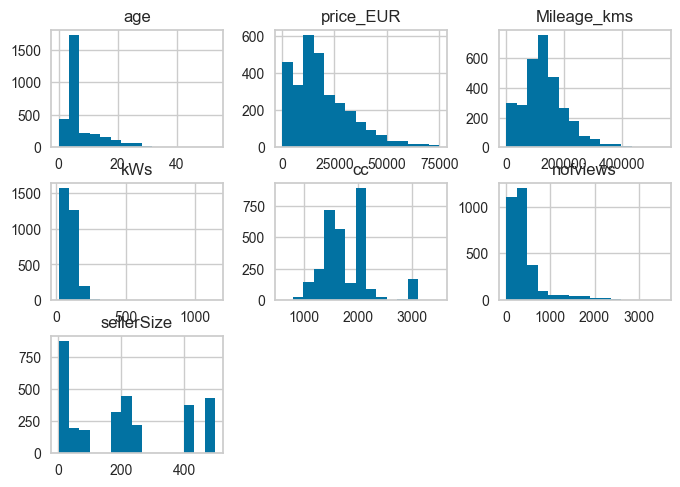

In [30]:
df=df.drop('price_kn',axis=1)    #buduci da nitko ne vara na tecaju cijene eur i kn je redund cuvati obe
df.hist(bins=15)

15     5     3041


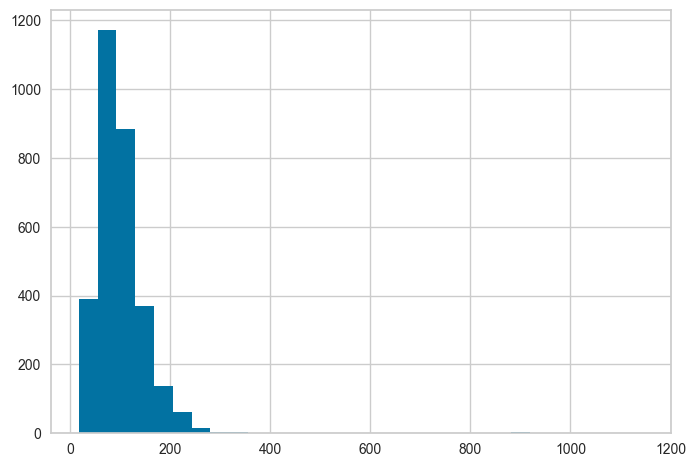

In [31]:
df["kWs"].hist(bins=30)
print(len(df[(df["kWs"]>=270)]) , "   ",len(df[(df["kWs"]<=30)]) ,"   ", len(df))
#ocito nisam jos ocistio outliere :)

In [32]:
df=df[(df["kWs"]<275)]

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'price_EUR'}>,
        <Axes: title={'center': 'Mileage_kms'}>,
        <Axes: title={'center': 'kWs'}>, <Axes: title={'center': 'cc'}>,
        <Axes: title={'center': 'nofviews'}>,
        <Axes: title={'center': 'sellerSize'}>]], dtype=object)

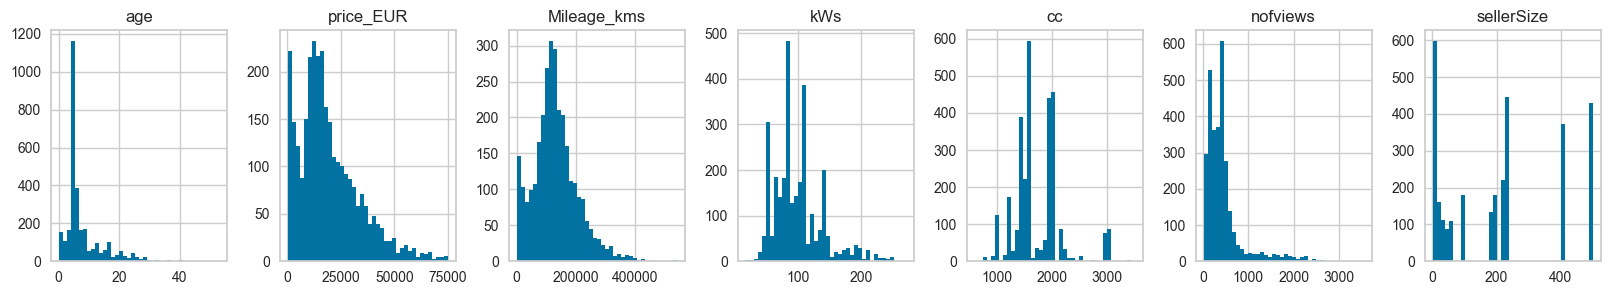

In [33]:
df.hist(bins=40,layout=(1,7),figsize=(20,3))

Could've cut more in age and nofviews, but decided that those aren't inherently normal-ish distributions. 

<Figure size 800x550 with 0 Axes>

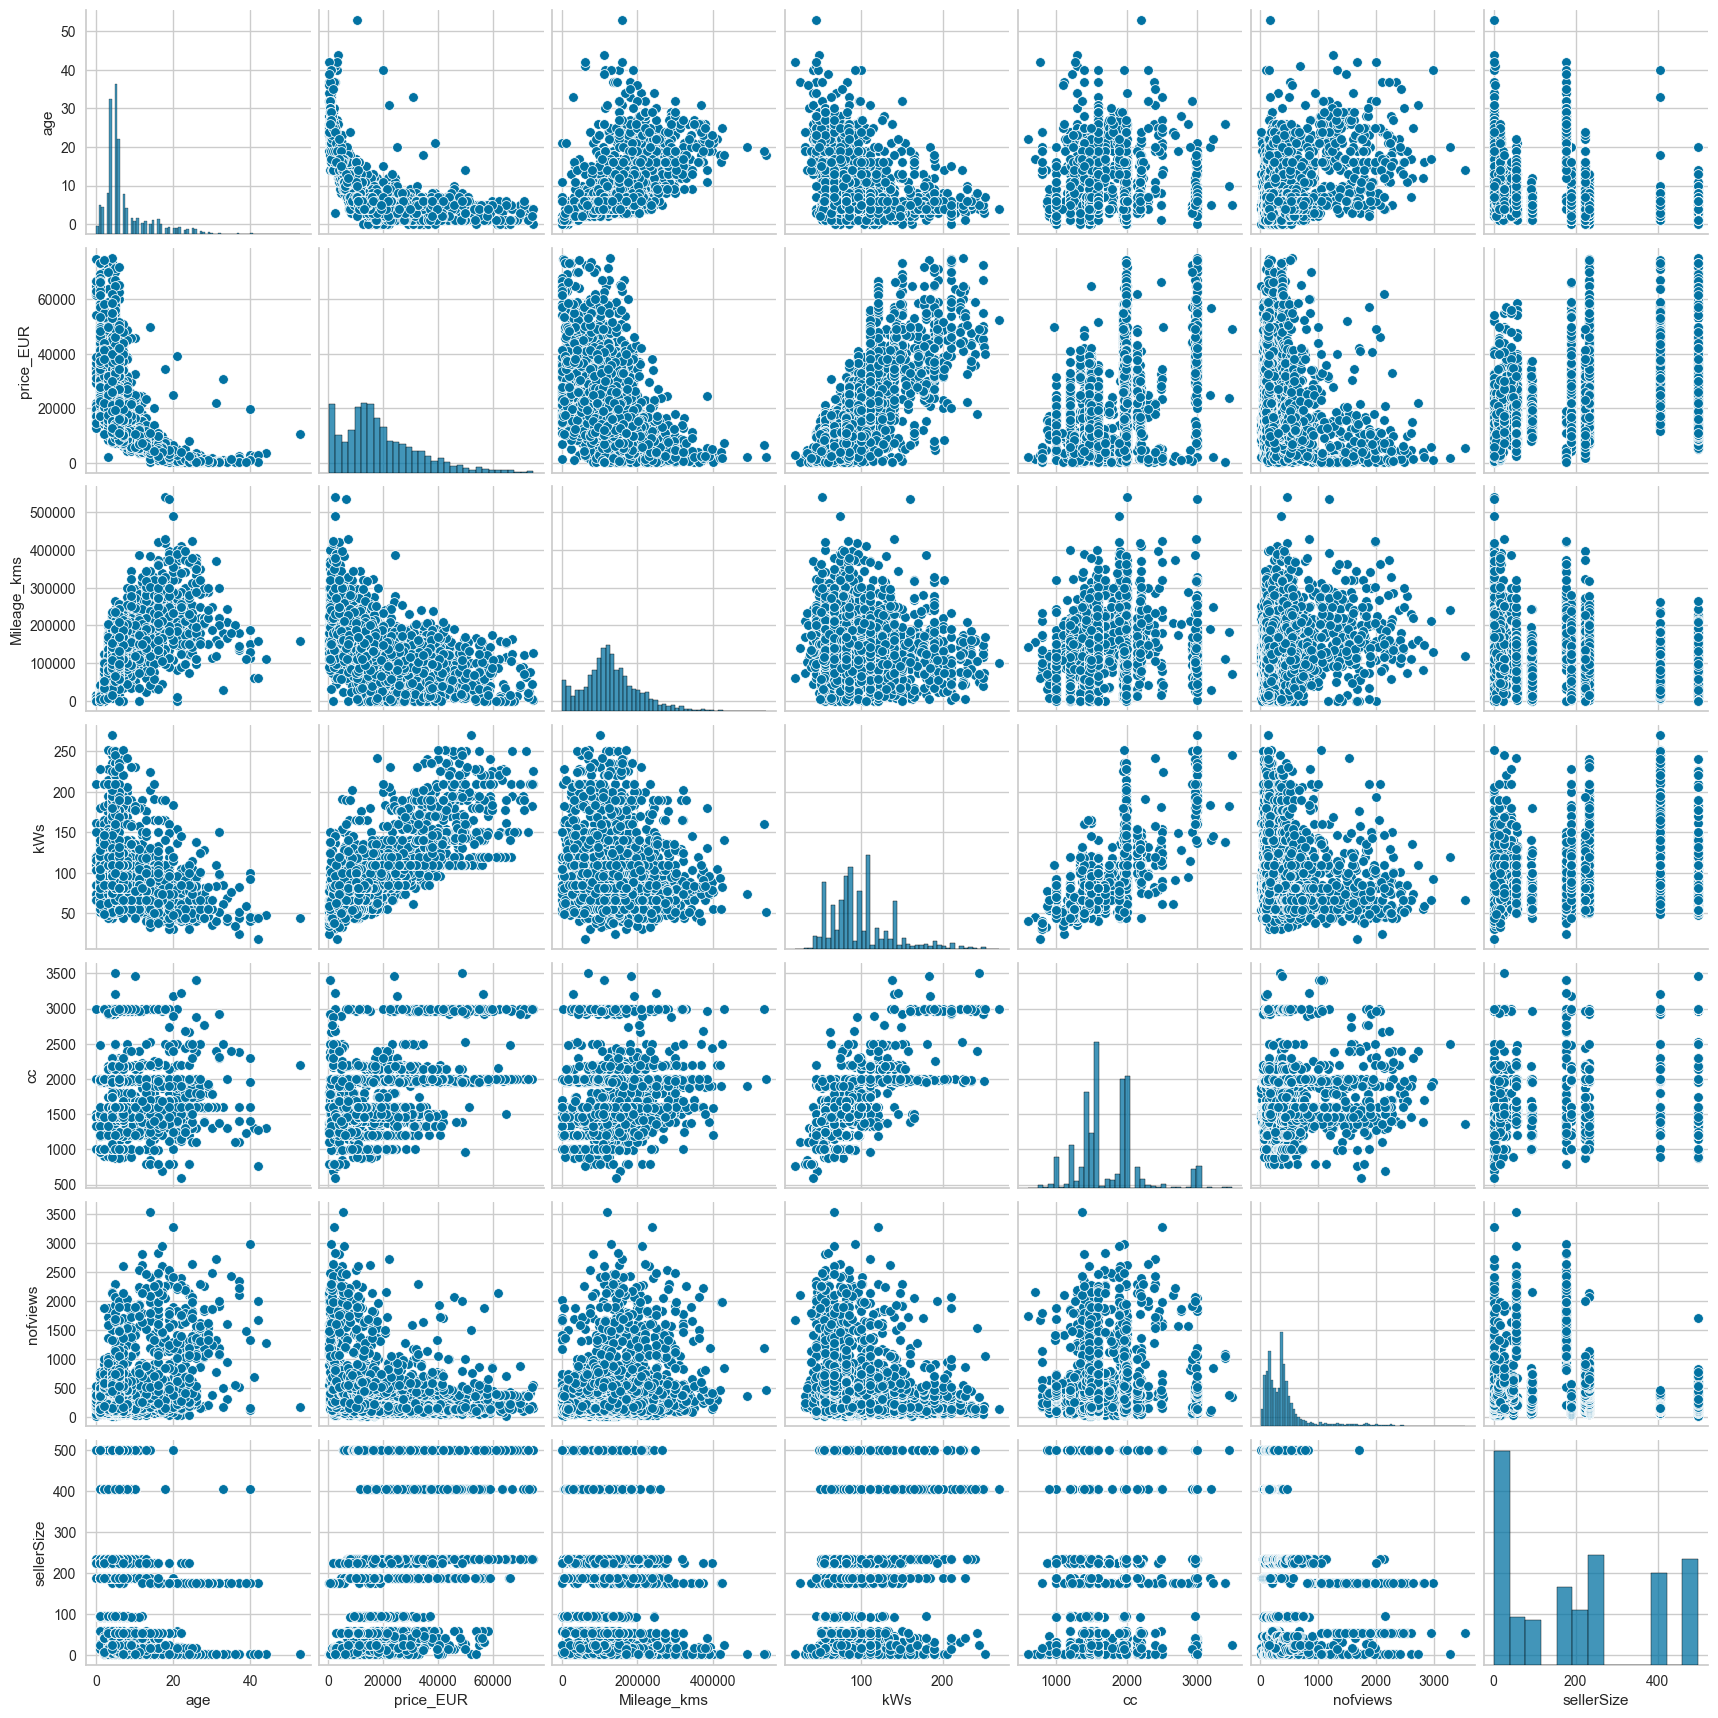

In [12]:
To_Plot = [ "age", "price_EUR", "Mileage_kms", "kWs", "cc", "nofviews","sellerSize"]  #no hue, don't have small(binary, trinary) categorical variables yet
plt.figure()
sns.pairplot(df[To_Plot])
plt.show()

Above: fishing for visual clues about dependencies and correlation. Negative correlation of "age" and "price", and weak positive correlation of "cc" and "kWs" which is both expected. 

Seller size is not very informative numeric variable.  I'll encode it further as seller class: 0- small, 1-medium, 2 -large. 

I'll try dimensionality reduction and kmeans on a copy of this data 

<Axes: >

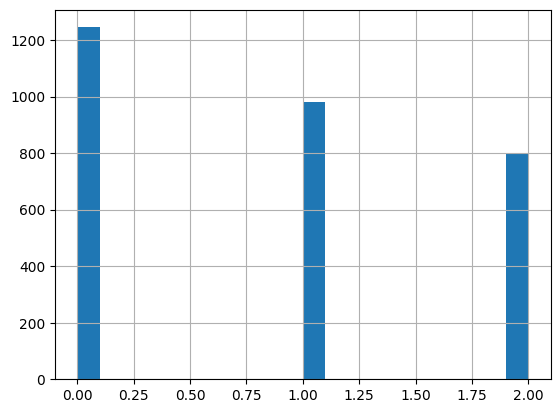

In [5]:
df["sellerBin"]= df["sellerSize"].apply(lambda x: int(x>100)+int(x>300))
df["sellerBin"].hist(bins=20)

<Figure size 800x550 with 0 Axes>

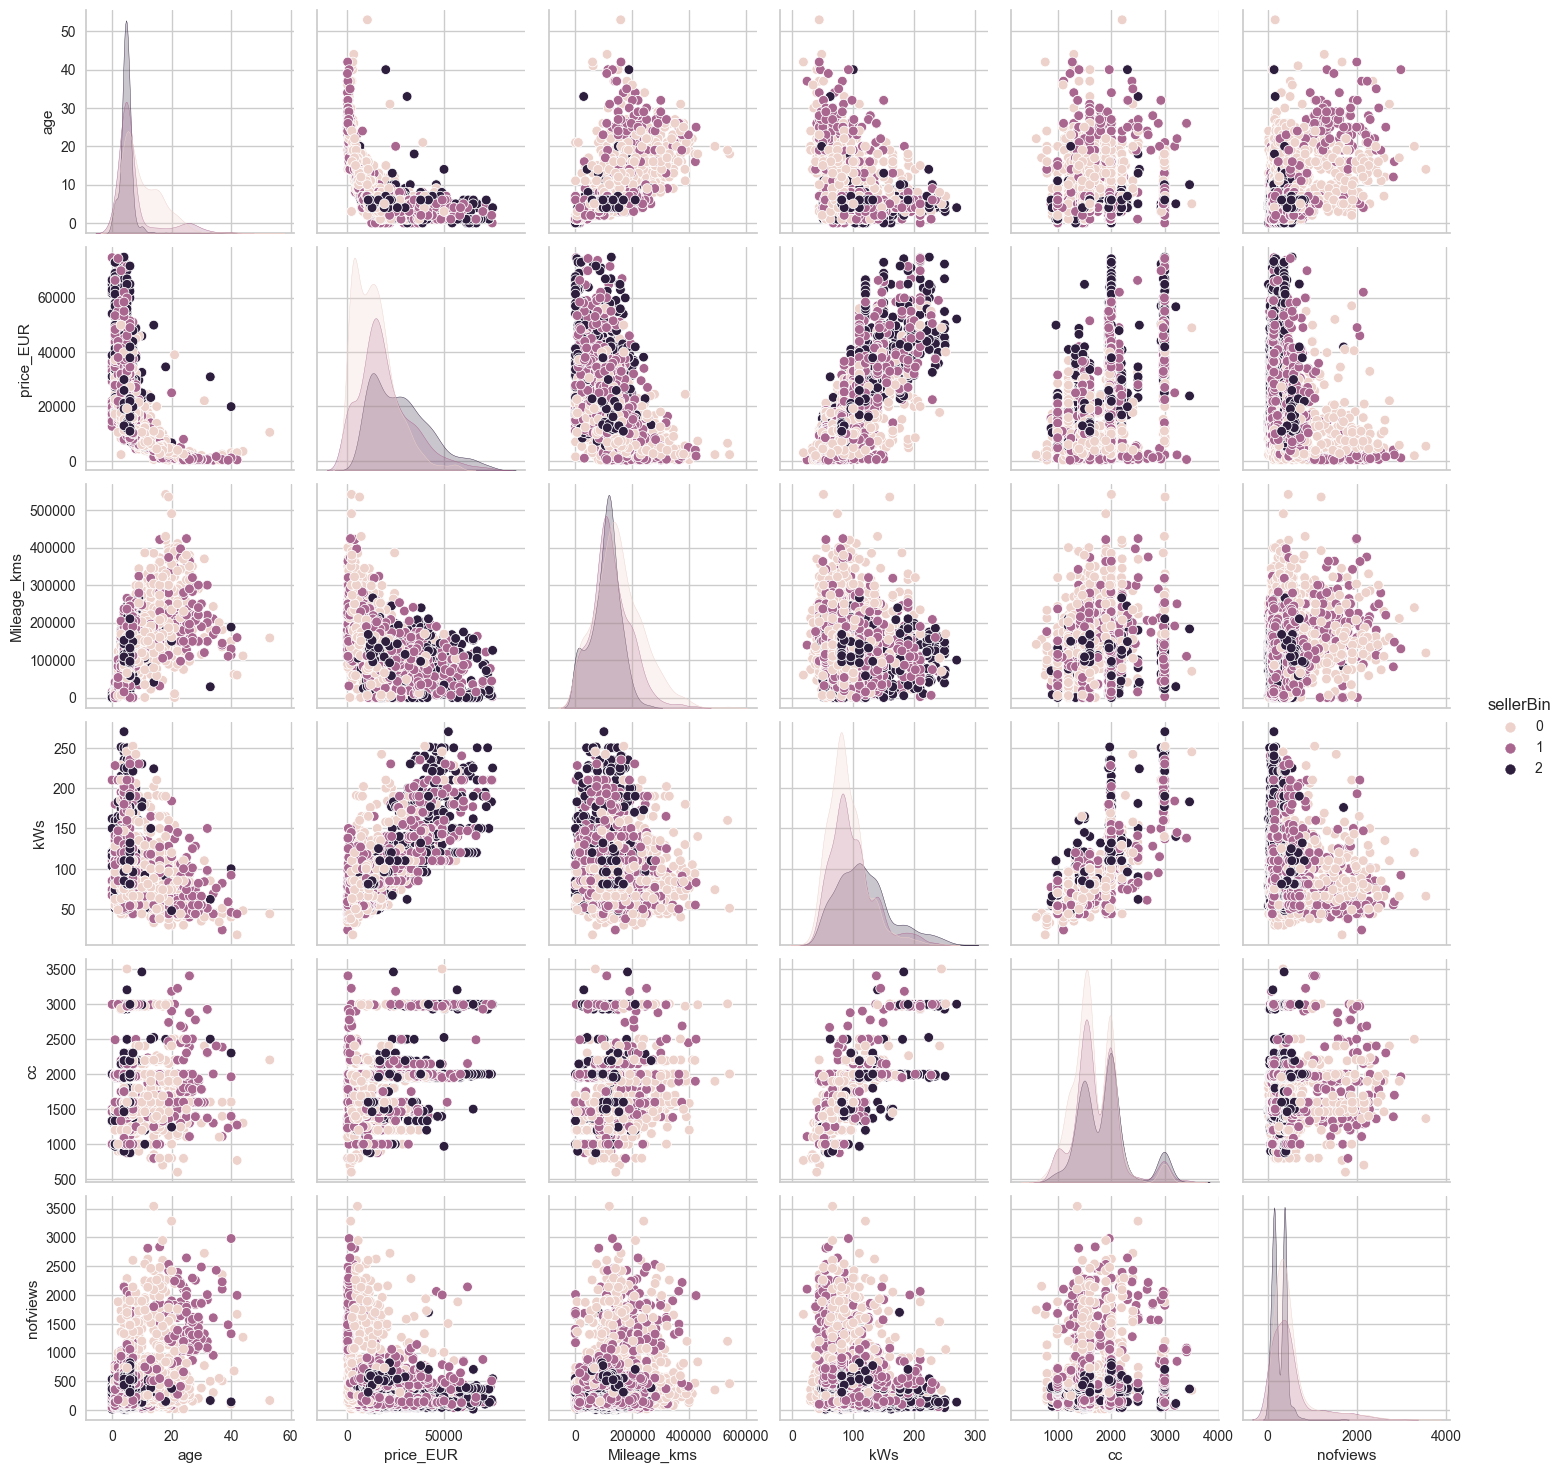

In [5]:
To_Plot = [ "age", "price_EUR", "Mileage_kms", "kWs", "cc", "nofviews","sellerBin"]
plt.figure()
sns.pairplot(df[To_Plot],hue="sellerBin")
plt.show()

Some scatterplots do look kind of separated by the sellerBin. Also some separation in car power, price and nofviews by sellerBin

<Axes: >

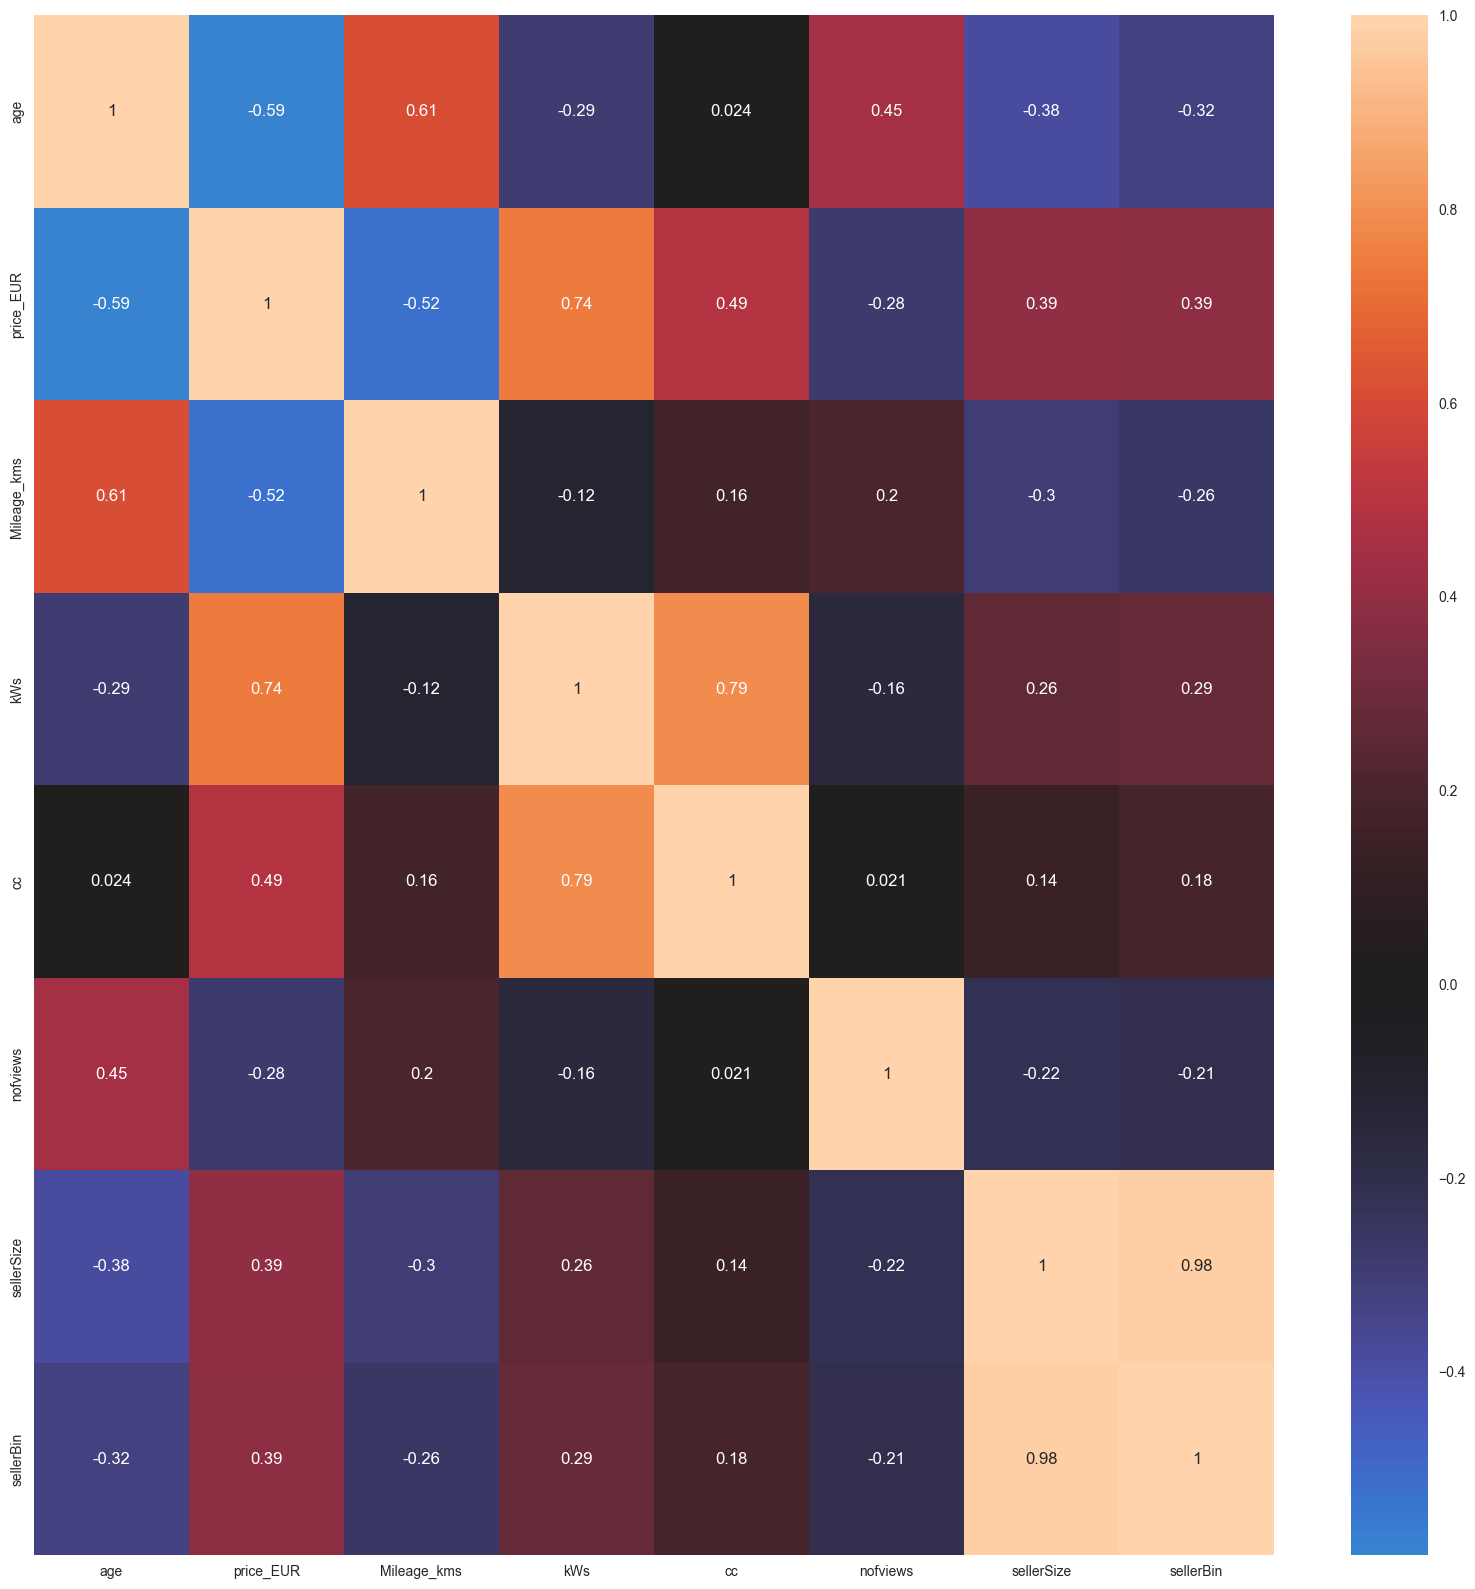

In [15]:
#correlation matrix
corrmat= df.corr()
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True,  center=0)

Very few significant correlations. Most significant negatives ~-0.59, -0.52, most significant positives around .61, .74, .79
sellersize and sellerBin are almost the same variable, so that 0.98 is more cautionary not to use them together. 

PCA attempt - I make a copy dataframe in which I only keep numerical data. Also SellerBin is dropped.
Data is scaled. I am aware that maybe standard scaler shouldn't be applied for the variables that are not quite normal. But for now it's what I know. 

In [35]:
ds=df.copy()                                    #iskopiram samo numericke i numerizabilne atribute/kolumne u pomocni frame 
s = (ds.dtypes == 'object')
object_cols = list(s[s].index)
#print(object_cols)
ds=ds.drop(object_cols, axis=1)
ds=ds.drop("sellerBin", axis=1)                 #njega bacam ca jer je skoro isti kao sellersize kad se skalira
#ds.info()

""" LE=LabelEncoder()
for i in object_cols:
    ds[i]=ds[[i]].apply(LE.fit_transform)  """#ne treba mi to, svi su vec numericki, samo trebam skalirati

scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
scaled_ds.describe()           #standard scaler skalira na N(0,1)... nisu mi sve varijable bile normalne... meljem dalje, mozda se vratim


age     price_EUR   Mileage_kms           kWs            cc  \
count  3.027000e+03  3.027000e+03  3.027000e+03  3.027000e+03  3.027000e+03   
mean  -1.877880e-17  3.755759e-17 -7.511519e-17  5.398904e-17 -2.370823e-16   
std    1.000165e+00  1.000165e+00  1.000165e+00  1.000165e+00  1.000165e+00   
min   -1.189204e+00 -1.353592e+00 -1.751637e+00 -2.095074e+00 -2.560576e+00   
25%   -5.805518e-01 -6.722844e-01 -6.172985e-01 -6.599323e-01 -6.280248e-01   
50%   -4.283888e-01 -2.429478e-01 -1.033513e-01 -3.011468e-01 -3.205225e-01   
75%    1.802631e-01  5.291541e-01  5.105475e-01  3.779828e-01  5.503601e-01   
max    6.875434e+00  3.902613e+00  5.503445e+00  4.363064e+00  3.944108e+00   

           nofviews   sellerSize  
count  3.027000e+03  3027.000000  
mean   1.877880e-17     0.000000  
std    1.000165e+00     1.000165  
min   -9.743429e-01    -1.142138  
25%   -6.131858e-01    -1.002542  
50%   -1.861573e-01    -0.076655  
75%    8.187122e-02     1.159760  
max    7.036984e+00     1.695350

In [9]:
# PCA - just for kicks, because the dimension is 7, already sufficiently small
# - with maximal number of components = minimum ( number of records -1, number of columns) =min(3000ish, 7)=7
# then I read the explained variance ratio, which gives me 'relevance' of each of the principal components

To_Plot=["col1","col2","c3","4","5","6","7"]

pca = PCA(n_components=7)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(To_Plot))
PCA_ds.describe().T
print(pca.explained_variance_ratio_)

""" plt.figure()
sns.pairplot(PCA_ds[To_Plot])
plt.show() """


[0.43837581 0.24844703 0.1200056  0.10525856 0.04484068 0.02546692
 0.0176054 ]


' plt.figure()\nsns.pairplot(PCA_ds[To_Plot])\nplt.show() '

So first two components cover 69% of the variance. If need be reduction from dim=7 to dim=2 is significant.
Further plan is to run kmeans on the dataset before the PCA, scaled_df, for few different ks, 
and compare it with kmeans segmentation yielded by PCA_df dataset.

Elbow Method to determine the number of clusters to be formed:


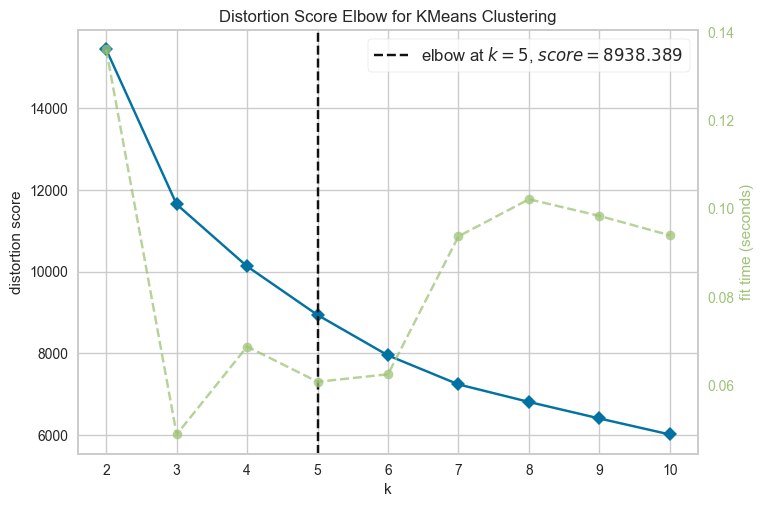

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [36]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(scaled_ds)                  #ran it for (full) PCA_ds also, it gave k=5 also.
Elbow_M.show()

https://datascience.stackexchange.com/questions/91182/when-should-we-choose-agglomerative-clustering-over-k-means-clustering

In [51]:
scaled_ds=scaled_ds.drop("clust1",axis=1)
scaled_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3027 entries, 0 to 3026
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          3027 non-null   float64
 1   price_EUR    3027 non-null   float64
 2   Mileage_kms  3027 non-null   float64
 3   kWs          3027 non-null   float64
 4   cc           3027 non-null   float64
 5   nofviews     3027 non-null   float64
 6   sellerSize   3027 non-null   float64
dtypes: float64(7)
memory usage: 165.7 KB


<Figure size 800x550 with 0 Axes>

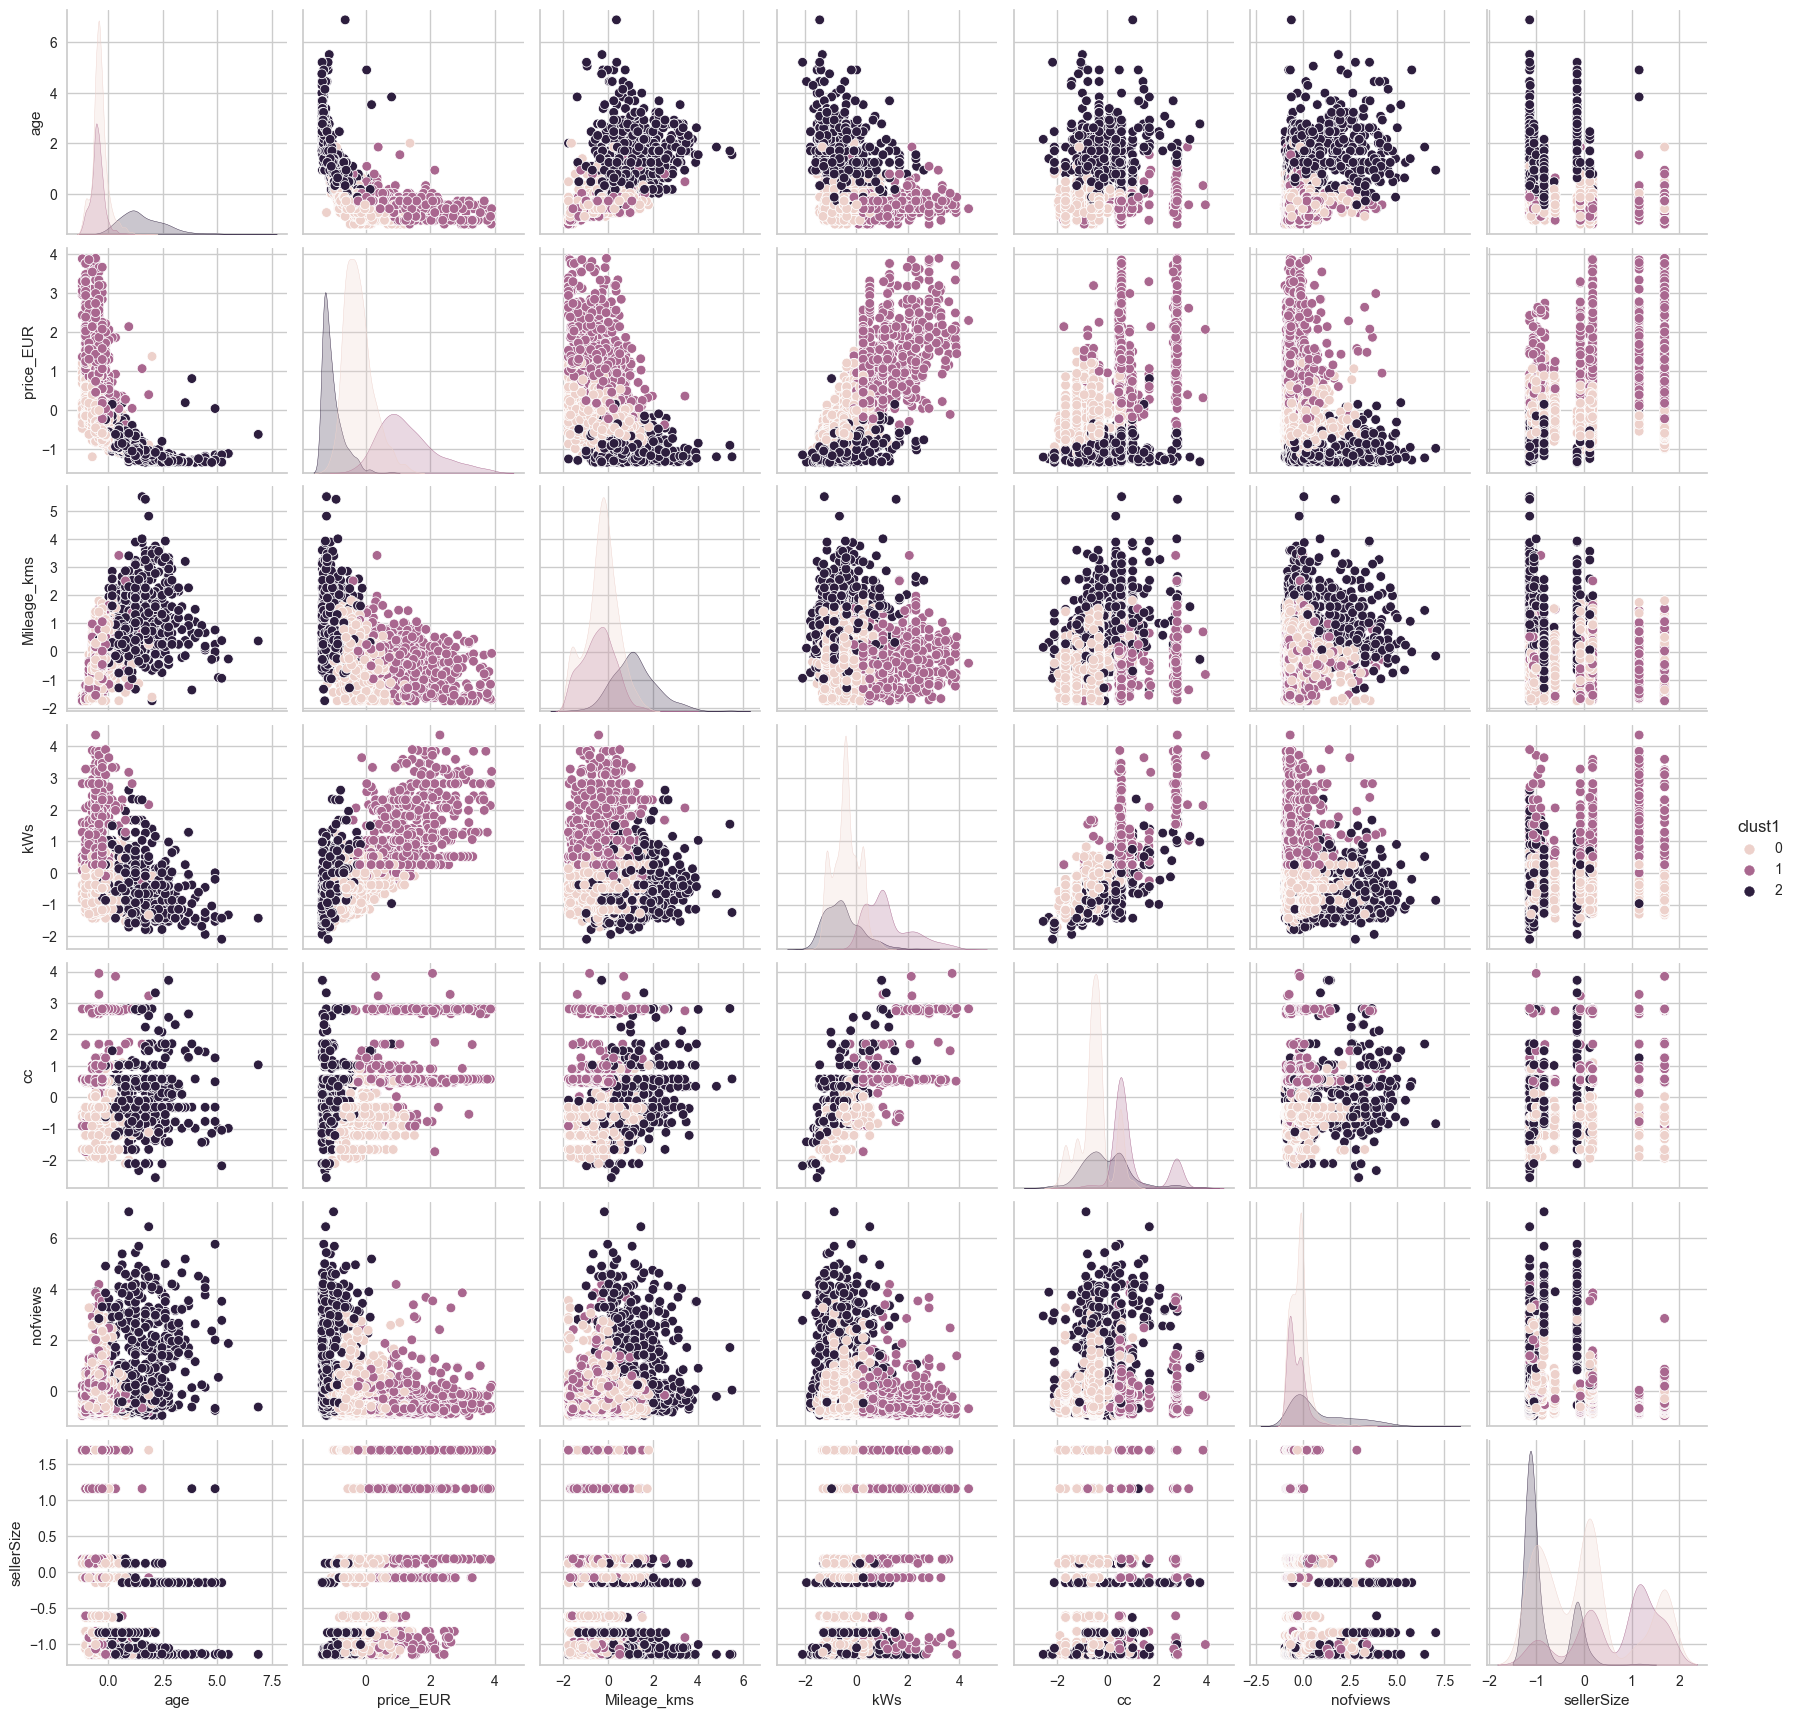

In [52]:
km=KMeans(n_clusters=3)   ########## number of clusters =3

scaled_ds["clust1"]=km.fit_predict(scaled_ds)
#km.cluster_centers_     
To_Plot = [ "age", "price_EUR", "Mileage_kms", "kWs", "cc", "nofviews","sellerSize","clust1"]
plt.figure()
sns.pairplot(scaled_ds[To_Plot],hue="clust1")
plt.show()

age - price, age - mileage, nofviews - price, and some other pairs also, show nice separation. 
I store the clustering info in new column. 

In [37]:
#df["cl02 kM=5 na nereduc norm scaled podacima"]=scaled_ds["clust1"]
#scaled_ds=scaled_ds.drop("clust1",axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3027 entries, 1 to 4490
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         3027 non-null   object 
 1   age           3027 non-null   float64
 2   price_EUR     3027 non-null   float64
 3   Mileage_kms   3027 non-null   float64
 4   kWs           3027 non-null   float64
 5   cc            3027 non-null   float64
 6   nofviews      3027 non-null   int64  
 7   manufacturer  3027 non-null   object 
 8   seller        3027 non-null   object 
 9   location      3027 non-null   object 
 10  ad_URL        3027 non-null   object 
 11  image         3027 non-null   object 
 12  sellerSize    3027 non-null   int64  
dtypes: float64(5), int64(2), object(6)
memory usage: 331.1+ KB


<Figure size 800x550 with 0 Axes>

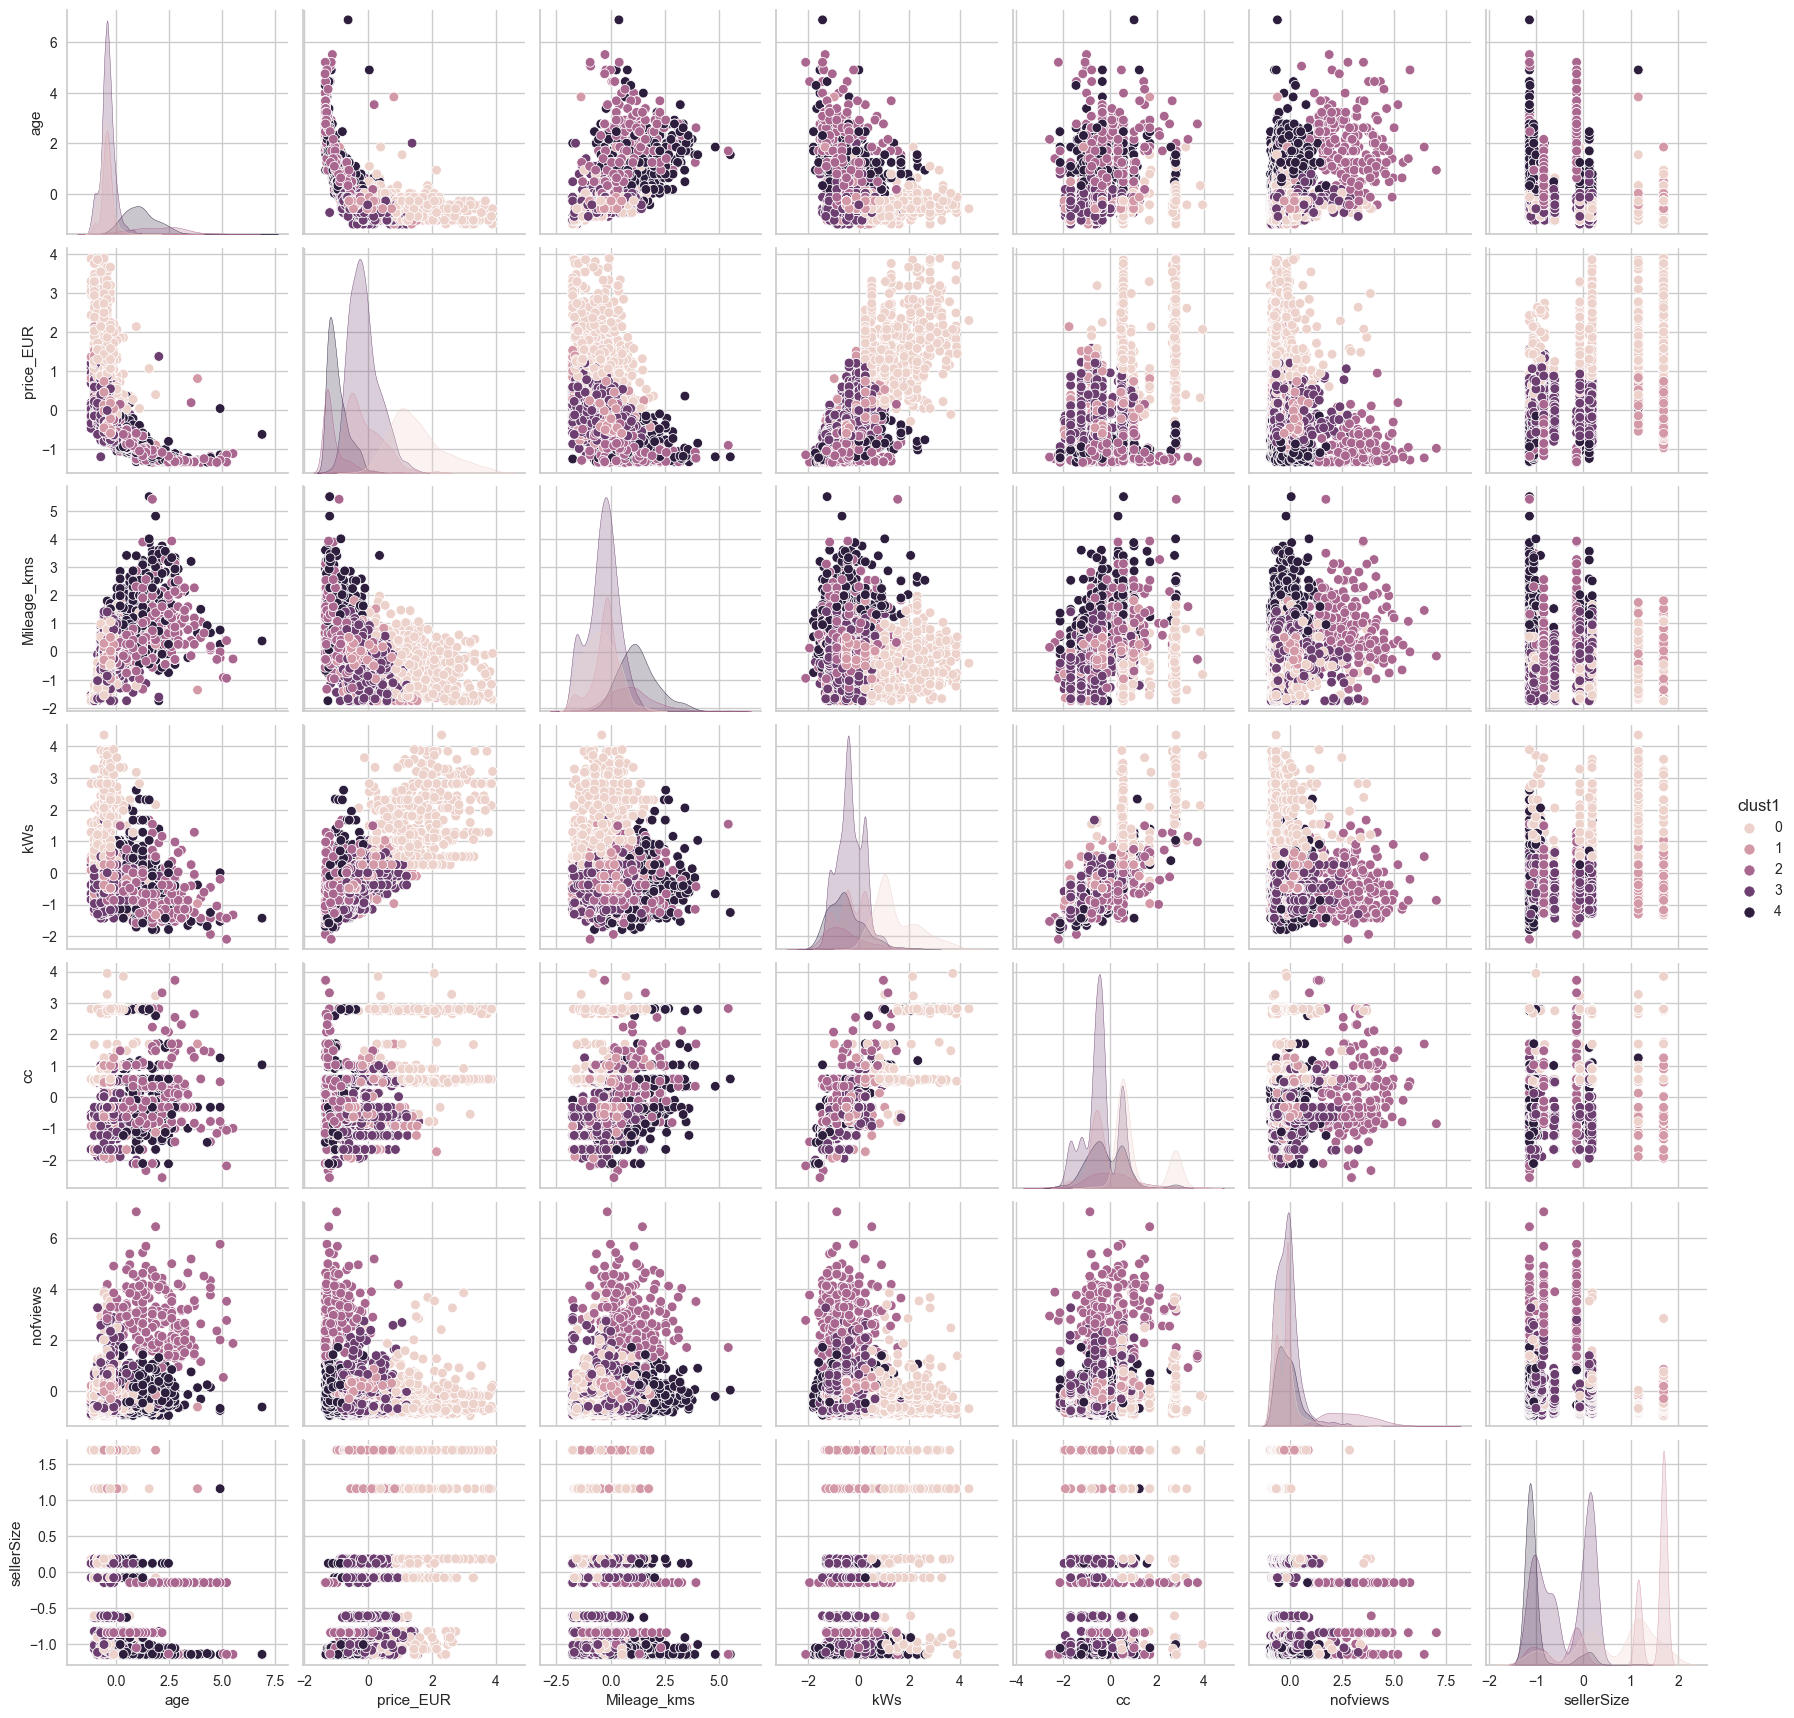

In [59]:
km=KMeans(n_clusters=5)    #### five clusters 

scaled_ds["clust1"]=km.fit_predict(scaled_ds)
#km.cluster_centers_
To_Plot = [ "age", "price_EUR", "Mileage_kms", "kWs", "cc", "nofviews","sellerSize","clust1"]
plt.figure()
sns.pairplot(scaled_ds[To_Plot],hue="clust1")
plt.show()

Looks a bit messier than 3 clusters. Still need to do more detailed cluster profiling. Especially check the cluster sizes. 